# Getting started
https://optax.readthedocs.io/en/latest/getting_started.html

## E.g. Fitting a Linear Model

In [5]:
import jax.numpy as jnp
import jax
import optax
import functools
import jax.random as r

In [4]:
@functools.partial(jax.vmap, in_axes=(None,0))
def network(params, x):
    return jnp.dot(params, x)

def compute_loss(params, x, y):
    y_pred = network(params, x)
    loss = jnp.mean(optax.l2_loss(y_pred, y))
    return loss

In [6]:
key = jax.random.key(42)
target_params = 0.5

# Generate some data
xs = r.normal(key, (16, 2))
ys = jnp.sum(xs * target_params, axis=1)

### Basic usage

In [20]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of model and optimizer
params = jnp.array([0., 0.])
opt_state = optimizer.init(params)

In [21]:
stores = []

for count in range(400):
    grads = jax.grad(compute_loss)(params, xs, ys)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if count in 2**jnp.arange(8):
        print(f'Iteration {count}, loss {compute_loss(params, xs, ys)}')
        stores.append(params)

assert jnp.allclose(params, target_params), \
'Optimization should retrieve the target parameters'

Iteration 1, loss 0.13446101546287537
Iteration 2, loss 0.06221400946378708
Iteration 4, loss 0.001146992202848196
Iteration 8, loss 0.05236002802848816
Iteration 16, loss 0.0026888251304626465


Iteration 32, loss 0.0014506187289953232
Iteration 64, loss 1.7872731632451178e-06
Iteration 128, loss 2.593407657514035e-07


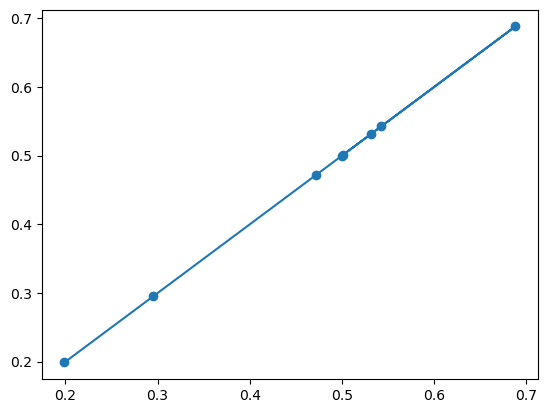

In [22]:
# plot the trajectory of the optimization
import matplotlib.pyplot as plt

plt.plot([store[0] for store in stores], [store[1] for store in stores], 'o-')

### Custom optimizers

In [23]:
# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=100,
    decay_rate=0.99
)

# Combining gradient transforms with `optax.chain`
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),
    # scale by -1 because want to minimize loss
    optax.scale(-1.)
)

In [24]:
# Initialize parameters of model and optimizer
params = jnp.array([0., 0.])
opt_state = gradient_transform.init(params)

# simple update loop
for _ in range(400):
    grads = jax.grad(compute_loss)(params, xs, ys)
    updates, opt_state = gradient_transform.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

### Advanced usage